# Exploring Bias and Variance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.optimize import minimize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)
np.set_printoptions(suppress = True)

## Regularized linear regression

#### Import data

In [2]:
data1 = loadmat('data/ex5data1.mat')

In [3]:
def plot_dataset( X, y, xlabel, ylabel, xmin, xmax, ymin, ymax, axes = None ):
    plt.plot( X, y, 'rx' )
    plt.axis([xmin, xmax, ymin, ymax])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

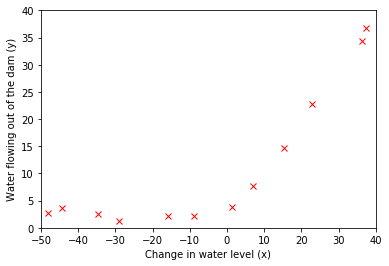

In [4]:
plot_dataset( data1['X'], data1['y'], 'Change in water level (x)', 'Water flowing out of the dam (y)', -50, 40, 0, 40 )

#### Regularized Linear regression

In [5]:
def linearRegCostFunction(theta, X, y, lmda):
    
    m = len(y) 
    J = 0
    
    grad = np.zeros(theta.size)
    theta = theta.reshape( X.shape[1], 1 )
    
    h = np.dot(X, theta)
    J = (0.5/m) * np.dot( ( h - y ).T, h - y ) + (0.5 * lmda/m) * np.sum( np.square(theta[1:]) )
    
    grad = ((1/m) * (h - y).T.dot( X )).T + (lmda/m) * np.r_[ [[0]], theta[1:] ]
    grad = np.r_[grad.ravel()]
    
    return (J, grad)

In [6]:
X = np.c_[np.ones( data1['X'].shape[0] ), data1['X']]
y = data1['y']

Xval = np.c_[np.ones( data1['Xval'].shape[0] ), data1['Xval']]
yval = data1['yval']

Xtest = np.c_[np.ones( data1['Xtest'].shape[0] ), data1['Xtest']]
ytest = data1['ytest']

theta = np.array([np.ones([2])]).T

print( 'Cost: ', linearRegCostFunction( theta, X, y, 1 )[0][0][0] )
print( 'Gradient: ', linearRegCostFunction( theta, X, y, 1 )[1] )

Cost:  303.9931922202643
Gradient:  [-15.30301567 598.25074417]


In [7]:
def trainLinearReg(X, y, lmda):
    
    initial_theta = np.zeros( [X.shape[1], 1] )
    theta = minimize( fun = linearRegCostFunction, x0 = initial_theta, 
              args = (X, y, lmda), 
              method = 'CG', jac = True, options = {'maxiter' : 200} )
    
    return theta

In [9]:
trained = trainLinearReg(X, y, 0)

print('Intercept: ', trained.x[0])
print('Slope: ', trained.x[1])

Intercept:  13.087903510869074
Slope:  0.36777922974565036


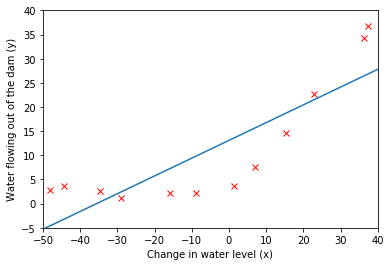

In [10]:
plot_dataset( data1['X'], data1['y'], 'Change in water level (x)', 'Water flowing out of the dam (y)', -50, 40, -5, 40 )
plt.plot([-50, 40], [-1*trained.x[1]*50 + trained.x[0] , trained.x[1]*40 + trained.x[0]] )

Clearly, assuming a linear relationship produces high bias (underfit). This is done on purpose to now explore how the learning curves would look like, so I get better at debugging a machine learning model.

## Bias - Variance

In [11]:
def learning_curve( X, y, Xval, yval, lmda ):
    
    m_train = X.shape[0]
    m_val = Xval.shape[0]
    
    error_train = np.zeros(m_train)
    error_val   = np.zeros(m_train)
    
    for i in range(m_train):
        
        data_set = X[0:i+1,:]
        labels = y[0:i+1,:]
        
        t = trainLinearReg( data_set, labels, lmda )
        theta_trained = t.x.reshape(X.shape[1],1)
        
        h_train = np.dot(data_set, theta_trained)
        h_val = np.dot( Xval, theta_trained )
        
        error_train[i] = np.sum(np.square( h_train - labels ))/(2*(i+1))
        error_val[i] = np.sum(np.square( h_val - yval ))/(2*m_val)
        
    return (error_train, error_val)

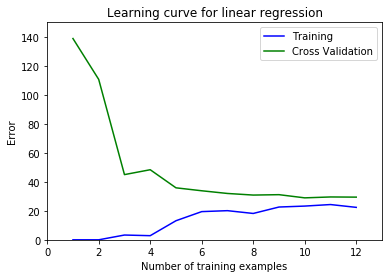

In [12]:
error_train, error_val = learning_curve( X, y, Xval, yval, 1 )
a = np.arange(1,error_train.size + 1)

plt.plot( a, error_train, '-b', label = 'Training' )
plt.plot( a, error_val, '-g', label = 'Cross Validation' )
plt.axis([0, 13, 0, 150])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
plt.title('Learning curve for linear regression')
plt.show()

**Observation**: As expected, in high bias scenario, the training and cross-validation error will be very close to each other. In this case, adding more training data will not improve the model.

## Polynomial Regression

In [14]:
def poly_features(X, p):
    
    X_poly = X.reshape(X.shape[0],1)
    
    for i in range(1, p):
        X_poly = np.c_[X_poly, np.power(X_poly[:,0], i + 1)]
    
    return X_poly

In [15]:
def feature_normalize(X):
    
    mu = np.mean(X, axis = 0)
    sigma = np.std(X,axis = 0)

    X_norm = (X - mu)/sigma
    
    return X_norm, mu, sigma

In [16]:
p = 8
X_poly = poly_features(data1['X'], p)

X_norm, mu, sigma = feature_normalize(X_poly)
X_poly = np.c_[np.ones(X_poly.shape[0]), X_norm]

X_poly_test = poly_features( data1['Xtest'], p )
X_poly_test = np.c_[ np.ones(X_poly_test.shape[0]), (X_poly_test - mu)/sigma ]

X_poly_val = poly_features( data1['Xval'], p )
X_poly_val = np.c_[ np.ones(X_poly_val.shape[0]), (X_poly_val - mu)/sigma ]

In [17]:
lmda = 0.0
theta = trainLinearReg( X_poly, y, lmda ).x.reshape(X_poly.shape[1],1)

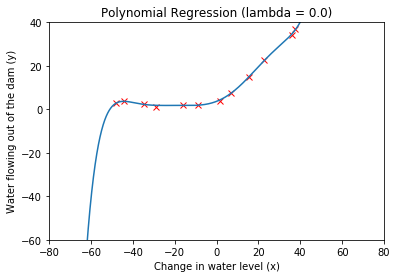

In [19]:
plot_dataset( data1['X'], data1['y'], 'Change in water level (x)', 'Water flowing out of the dam (y)', -80, 80, -60, 40 )

x = np.arange( np.amin(data1['X']) - 15, np.amax(data1['X']) + 25, 0.05 )
x_poly = poly_features(x, p)
x_poly = np.c_[ np.ones(x_poly.shape[0]), (x_poly - mu)/sigma ]

plt.title(f'Polynomial Regression (lambda = {lmda})') 
plt.plot( x, x_poly.dot(theta))

Forcing high variance by overfitting to observe the learning curve.

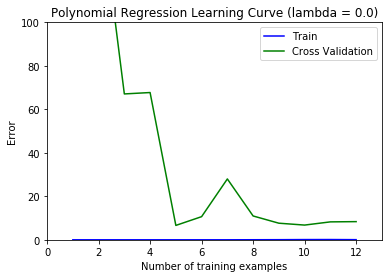

In [17]:
error_train, error_val = learning_curve( X_poly, y, X_poly_val, yval, lmda )

plt.plot( np.arange(1, error_train.size + 1), error_train, '-b', label = 'Train' )
plt.plot( np.arange(1, error_train.size + 1), error_val, '-g', label = 'Cross Validation' )
plt.axis([0, error_train.size + 1, 0, 100])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
plt.title(f'Polynomial Regression Learning Curve (lambda = {lmda})')
plt.show()

**Observation**: Again, the learning curve is as expected in a high variance scenario. There is a larger gap between the training error and the cross-validation error. Notice also that the training error basically 0, since the model overfits the training set.

#### Changing the regularization parameter

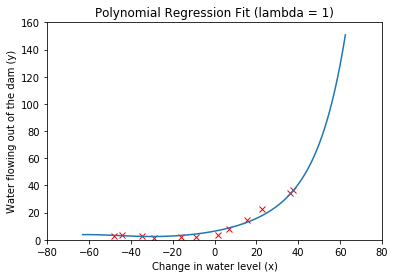

In [20]:
lmda_1 = 1
theta_1 = trainLinearReg( X_poly, y, lmda_1 ).x.reshape(X_poly.shape[1],1)

plot_dataset( data1['X'], data1['y'], 'Change in water level (x)', 'Water flowing out of the dam (y)', -80, 80, 0, 160 )

x = np.arange( np.amin(data1['X']) - 15, np.amax(data1['X']) + 25, 0.05 )
x_poly = poly_features(x, p)
x_poly = np.c_[ np.ones(x_poly.shape[0]), (x_poly - mu)/sigma ]

plt.title(f'Polynomial Regression Fit (lambda = {lmda_1})')
plt.plot( x, x_poly.dot(theta_1))

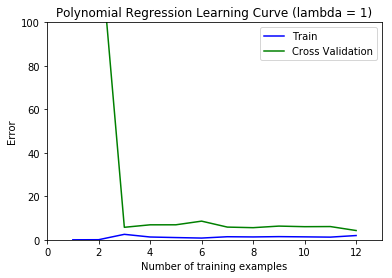

In [21]:
error_train, error_val = learning_curve( X_poly, y, X_poly_val, yval, lmda_1 )
a = np.arange(1,error_train.size + 1)

plt.plot( a, error_train, '-b', label = 'Train' )
plt.plot( a, error_val, '-g', label = 'Cross Validation' )
plt.axis([0, error_train.size + 1, 0, 100])
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.legend()
plt.title(f'Polynomial Regression Learning Curve (lambda = {lmda_1})')
plt.show()

**Observation**: Here, the regularization parameter was increased, which slightly improves the model presented with high variance.

#### High regularization parameter

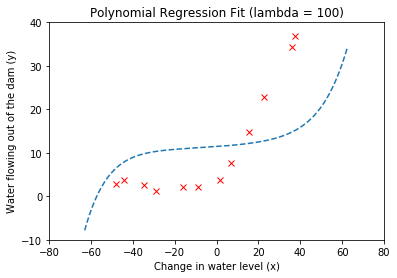

In [20]:
lmda_100 = 100
theta_100 = trainLinearReg( X_poly, y, lmda_100 ).x.reshape(X_poly.shape[1],1)

plot_dataset( data1['X'], data1['y'], 'Change in water level (x)', 'Water flowing out of the dam (y)', -80, 80, -10, 40 )
x = np.arange( np.amin(data1['X']) - 15, np.amax(data1['X']) + 25, 0.05 )
x_poly = poly_features(x, p)
x_poly = np.c_[ np.ones(x_poly.shape[0]), (x_poly - mu)/sigma ]
plt.title(f'Polynomial Regression Fit (lambda = {lmda_100})') # python 3.6
plt.plot( x, x_poly.dot(theta_100), '--' )

In [22]:
def validation_curve( X, y, Xval, yval ):
    
    lmda_vec = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    
    m_train = X.shape[0]
    m_val = Xval.shape[0]
    
    error_train = np.zeros(lmda_vec.size)
    error_val   = np.zeros(lmda_vec.size)
    
    for i in range(lmda_vec.size):
        
        lmda = lmda_vec[i]
        theta_trained = trainLinearReg( X, y, lmda ).x.reshape(X.shape[1],1)
        
        h_train = np.dot( X, theta_trained )
        h_val = np.dot( Xval, theta_trained )
        
        error_train[i] = np.sum(np.square( h_train - y ))/(2*(m_train))
        error_val[i] = np.sum(np.square( h_val - yval ))/(2*m_val)
        
    return (lmda_vec, error_train, error_val)

In [23]:
lmda_vec, error_train, error_val = validation_curve( X_poly, y, X_poly_val, yval )

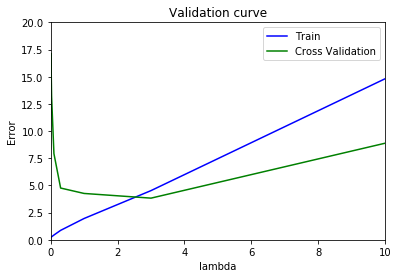

In [24]:
a = np.arange(1,error_train.size + 1)

plt.plot( lmda_vec, error_train, '-b', label = 'Train' )
plt.plot( lmda_vec, error_val, '-g', label = 'Cross Validation' )
plt.axis([0, np.amax(lmda_vec), 0, 20])
plt.xlabel('lambda')
plt.ylabel('Error')
plt.legend()
plt.title('Validation curve')
plt.show()

**Observation**: A high regularization parameter brings back the problem of high bias (underfitting). Therefore, the learning curves show a large difference between the training and cross-validation error. 

From the graph above, a regularization parameter of 3 seems to be the ideal value to minimze cross-validation error.

In [25]:
lmda = 3

theta_trained = trainLinearReg( X_poly, y, lmda ).x.reshape(X_poly.shape[1], 1)

h_test = np.dot( X_poly_test, theta_trained )

test_error = np.sum(np.square( h_test - ytest ))/(2*Xtest.shape[0])

print(f'Test error = {test_error}')

Test error = 3.5720266192172687
